In [23]:
%pip install gymnasium[classic_control]

zsh:1: no matches found: gymnasium[classic_control]
Note: you may need to restart the kernel to use updated packages.


In [24]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [25]:
env = gym.make("CartPole-v1")
is_ipython = 'inline' in plt.get_backend()
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [27]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [28]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

In [29]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

In [30]:
def plot_duration(show_result=False):
    plt.figure(1)
    duration_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(duration_t.numpy())

    if len(duration_t) >= 100:
        means = duration_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))  # Fixed typo here
        plt.plot(means.numpy())
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            plt.show()
        else:
            display.display(plt.gcf())

In [31]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update target network using Polyak averaging
    for target_param, param in zip(target_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

In [32]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 500

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0

    for t in count():
        action = select_action(state)
        observation, reward, terminated, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        total_reward += reward.item()
        done = terminated or (t == env._max_episode_steps - 1)

        if not done:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()

        if done:
            episode_durations.append(total_reward)
            # plot_duration()
            break

Complete


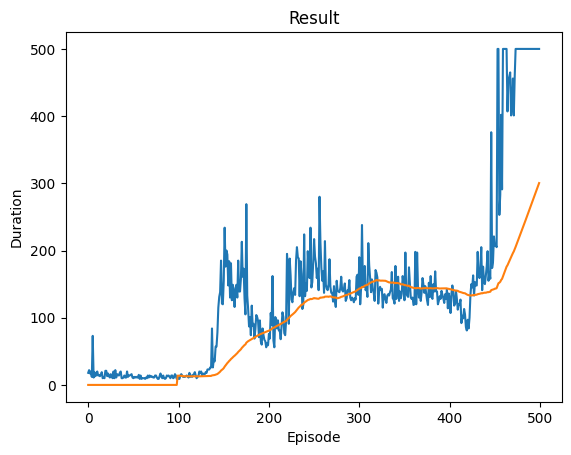

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [33]:
print('Complete')
plot_duration(show_result=True)
plt.ioff()
plt.show()